### Objectives

First, create a graph representation of the information we have. 
This would be information about the elements, and the nodes. 
Using this, we will feed it into our SVM, or a Random Forest, and see from there onwards

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import re

import torch
import torch.nn as nn
import numpy as np
import ast
import io

import plotly.graph_objs as go

# Set up torch to use CUDA or MPS if either are available
device = torch.device('cuda:0')  if torch.cuda.is_available() else torch.device('mps:0') if torch.backends.mps.is_available() else torch.device('cpu')
torch.set_default_device(device)

USE_NEW_FEATURES = True
USE_ONLY_3D_CNN_FEATURES = True
TRAIN_SVM = False
TRAIN_RF = False

MLP_MODEL_PATH = './mlp_regressor.pth'
LOAD_MLP_MODEL = False
SAVE_MLP_MODEL = True

In [6]:
# n = pd.read_csv('./full_node_Table_.csv')
df = pd.read_csv('./full_Table_.csv')

In [7]:
datafrac = 1
# This cell reads the data from the CSV file and cleans it up

if(USE_NEW_FEATURES):

    # Set pandas options to display all columns and rows
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)

    csv_file_path = 'full_Table_All_Cells_With_Angles_And_Edges_CLEANED.csv'
    buffer = io.StringIO()

    # Open and process the CSV file, to strip entries so that numbers aren't read as strings by read_csv and column names have no leading/trailing whitespaces
    with open(csv_file_path, 'r') as file:
        for line in file:
            cleaned_line = ','.join(cell.strip() for cell in line.split(','))
            buffer.write(cleaned_line + '\n')

    # Move the buffer cursor to the start
    buffer.seek(0)

    # Read the cleaned data into pandas
    data = pd.read_csv(buffer)
    edge_columns = [col for col in data.columns if col.startswith('edge_') and col.split('_')[-1].isdigit()]
    # Replace empty entries with 0 in these columns
    data[edge_columns] = data[edge_columns].fillna(0)

    # Not sure if these folder names are required for segregating the dataset, so for now dropping them
    # data = data.drop(columns=['folder_name_x', 'folder_name_x.1', 'folder_name_y'])
    data = data.drop(columns=['folder_name_x.1']) # 'folder_name_x' not dropping here, dropping in sample_data
    
    # Make each string in folder_name_y correspond to an integer instead
    unique_strings = data['folder_name_y'].unique()
    string_to_int_mapping = {string: i+1 for i, string in enumerate(unique_strings)}
    
    data['folder_name_y'] = data['folder_name_y'].replace(string_to_int_mapping)
    
    # For now, we aren't using the 555 channel either
    data = data.drop(columns=['element_pixel_intensity_555'])

    # These fields seem to be not implemented either:
    data = data.drop(columns=["Unnamed: 0_x", "x", "y" ,"z" ,"node_x" ,"degree_x" ,"vol_cc_x" ,"avg_PK_Of_element_x" ,"element_connectivity_x" ,"Unnamed: 0_y"])

    # The next few lines of code are to convert the degree_distribution column to columns labelled node_degree_0, node_degree_1, etc. till node_degree_MAX
    def str_to_dict(s):
        try:
            return ast.literal_eval(s)
        except ValueError:
            return {}
    # Apply the function to the 'degree_distribution' column
    data['degree_distribution'] = data['degree_distribution'].apply(str_to_dict)
        
    # Find the highest node degree in the DataFrame
    max_degree = max(degree for row in data['degree_distribution'] for degree in row.keys())

    # Create a DataFrame for new columns
    new_columns = pd.DataFrame({f'node_degree_{i}': 0 for i in range(1, max_degree + 1)}, index=data.index)

    # Concatenate with the original DataFrame
    data = pd.concat([data, new_columns], axis=1)
        
    # Function to update the degree columns for a row
    def update_degrees(row):
        for degree, count in row['degree_distribution'].items():
            row[f'node_degree_{degree}'] = count
        return row

    # Apply the function to each row
    data = data.apply(update_degrees, axis=1)
    data = data.drop(columns=['degree_distribution'])
    # Now we should have columns labelled node_degree_0, node_degree_1, etc. till node_degree_MAX and dropped the degree_distribution column

    data['cc_average_connectivity'] = data['cc_average_connectivity'].replace([np.inf, -np.inf], 0)

    data['cc_pixel_intensity_488'] = data['cc_pixel_intensity_488'].replace(0, np.nan)
    data = data.dropna(subset=['cc_pixel_intensity_488'])
    
    data['cc_pixel_intensity_405_488_ratio'] = ((np.array(data['cc_pixel_intensity_405']) / np.array(data['cc_pixel_intensity_488']))*1000).copy()
    # data['cc_pixel_intensity_ratio'] = (np.array(data['cc_pixel_intensity_ratio']) * 1000).copy()
    # Add feature vectors from CNN obtained image vectors
    
    # data.drop('image_name', axis=1, inplace=True)
    data['image_name'] = data['folder_name_x'] + '_' + data['cc_x'].astype(str)
    data['file_name'] = data['image_name'] + '.tif'
    
    if(USE_ONLY_3D_CNN_FEATURES):
        feature_vectors_df = pd.read_csv('image_feature_vectors.csv')

        data = pd.merge(data, feature_vectors_df, left_on='image_name', right_on='Image Name', how='left')
        data.drop('Image Name', axis=1, inplace=True)
        
        angle_columns = data.filter(regex='^Angle_\d+_\d+$').columns
        edge_columns = data.filter(regex='^edge_\d+$').columns
        columns_to_drop = angle_columns.union(edge_columns).union(['Angle_Flag'])
        data.drop(columns=columns_to_drop, inplace=True)
    # Replace any remaining NaN's with 0
    data.fillna(0, inplace=True)

    # Train on small subset of data to see if it works first, if datafrac <1
    sample_data = data.sample(frac=datafrac ,random_state=1049)
    sample_data = sample_data.drop(columns=['folder_name_x', 'line_id', 'folder_name_y', ])
    


    # Split the data into training and testing sets
    X = sample_data.drop(columns=['element_pixel_intensity_488'])
    X = X.drop(['cc_pixel_intensity_488',
                'cc_pixel_intensity_405',
                'cc_x', 'x_y', 'y_y', 'z_y', 'cc_y', 
                'pixel_intensity_405',
                'pixel_intensity_ratio',
                # 'pixel_intensity_555',
                'element_pixel_intensity_405',
                'element_pixel_intensity_ratio',
                'cc_average_connectivity',
                # 'cc_pixel_intensity_555',
                'cc_pixel_intensity_ratio', 
                'pixel_intensity',
                'pixel_intensity_488'], axis=1)
    
    # columns_with_NaN = sample_data.columns.to_series()[sample_data.apply(lambda x: np.isnan(x).any())]
    # if(len(columns_with_NaN) > 0):
    #     print(columns_with_NaN.values)
    #     raise Exception('Columns with NaN values found in dataset, can\'t train model on it directly')
    
    # non_numerical_columns = sample_data.select_dtypes(exclude=['int', 'float', 'double']).columns
    # # Print the non-numerical column names
    # if(len(non_numerical_columns) > 0):
    #     print(non_numerical_columns)
    #     raise Exception('Non-numerical columns found in dataset, can\'t train model on it directly')
    
    # # Print any columns with values like infinity
    # columns_with_infinity = sample_data.columns.to_series()[sample_data.apply(lambda x: np.isinf(x).any())]
    # if(len(columns_with_infinity) > 0):
    #     print(columns_with_infinity)
    #     raise Exception('Columns with infinity values found in dataset, can\'t train model on it directly')

C:\Users\rithi\AppData\Local\Temp\ipykernel_13544\2282505928.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['folder_name_y'] = data['folder_name_y'].replace(string_to_int_mapping)
C:\Users\rithi\AppData\Local\Temp\ipykernel_13544\2282505928.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['cc_pixel_intensity_405_488_ratio'] = ((np.array(data['cc_pixel_intensity_405']) / np.array(data['cc_pixel_intensity_488']))*1000).copy()
C:\Users\rithi\AppData\Local\Temp\ipykernel_13544\2282505928.py:84: PerformanceWarning:

In [8]:
# Adding a new column for file names in the DataFrame


# alter this for test train split

# data['file_name'] = data.apply(lambda row: f"{row['folder_name_x']}_{row['cc_x']}.tif", axis=1)

# turn file_name into a number 
unique_strings = data['file_name'].unique()


# Selecting only the required columns
output_data = data[['file_name', 'cc_pixel_intensity_405_488_ratio']]

# Writing the selected data to a CSV file
output_data.to_csv("./imageNames_ratios.csv", index=False)

print("Data successfully written to ./imageNames_ratios.csv")


Data successfully written to ./imageNames_ratios.csv


In [9]:
if(USE_NEW_FEATURES):
    # X_transformed_pca, dataset_pca_sklearn_obj = get_pca_transformation_and_scaled_dataset(X, 256)
    # now without the insane number of features from the sparse matrix from Angle_x_y and edge_x, there are only 184 features
    # because we are now using the CNN image vectors
    
    # X_transformed_pca, dataset_pca_sklearn_obj = get_pca_transformation_and_scaled_dataset(X, 184)
    
    # explained_var = dataset_pca_sklearn_obj.explained_variance_ratio_

    # # Calculate and sort feature contributions
    # feature_contributions = feature_contribution_to_variance(dataset_pca_sklearn_obj, explained_var, X.columns)
    # plot_feature_contributions(feature_contributions)
    
    # We're basically predicting
    # (405 / 488) * 1000

    Y = sample_data['cc_pixel_intensity_405_488_ratio']

    # # Perform standardization on X and Y
    # scalerX = StandardScaler()
    # scalerY = StandardScaler()

    # apply the scalers


    y = np.rint(Y).astype(int)
    df_for_binning = pd.DataFrame(X)  # Convert features to DataFrame for easier manipulation
    df_for_binning['y'] = y  # Add your target variable 'y' to the DataFrame

    # Bin the DataFrame based on 'y' values
    bin_1 = df_for_binning[df_for_binning['y'] < 250]
    bin_2 = df_for_binning[df_for_binning['y'] >= 250]

    # Split each bin into training and testing sets
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(bin_1.drop(columns=['y']), bin_1['y'], test_size=0.2, random_state=39)
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(bin_2.drop(columns=['y']), bin_2['y'], test_size=0.2, random_state=39)

    # Combine the splits from both bins to form the final training and testing sets
    X_train = pd.concat([X_train_1, X_train_2])
    X_test = pd.concat([X_test_1, X_test_2])
    y_train = pd.concat([y_train_1, y_train_2])
    y_test = pd.concat([y_test_1, y_test_2])

    print("The training data shapes are:", X_train.shape, y_train.shape, "and the testing data shapes are:", X_test.shape, y_test.shape)


The training data shapes are: (9645, 184) (9645,) and the testing data shapes are: (2412, 184) (2412,)


In [10]:
def plot_error_frequency(y_pred, y_test, classifier_title, rounding):
    rounding_ = rounding//2
    
    # Calculate errors
    errors = (abs(y_pred - y_test) < rounding_)

    # Extract labels where errors occurred
    error_labels = y_test[errors]

    # Calculate frequency of each label
    unique_labels, counts = np.unique(error_labels, return_counts=True)

    # Creating a dictionary of label frequencies for errors
    label_error_frequency = dict(zip(unique_labels, counts))

    # Finding the range of all possible labels (from min to max in y_test and y_pred)
    all_labels = np.unique(np.concatenate((y_test, y_pred)))
    min_label = min(all_labels)
    max_label = max(all_labels)

    # Filling in frequencies for labels that did not have errors
    for label in range(min_label, max_label + 1):
        if label not in label_error_frequency:
            label_error_frequency[label] = 0

    # Sorting the dictionary for plotting
    sorted_label_error_frequency = dict(sorted(label_error_frequency.items()))

    xticks = np.arange(min_label, max_label + 1, 50)

    # Plotting the error frequency
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_label_error_frequency.keys(), sorted_label_error_frequency.values())
    plt.xlabel('Prediction')
    plt.ylabel('Error Frequency')
    plt.title('Error Frequency Distribution for ' + str(classifier_title) + ' for errors >= {} ({} in either direction)'.format(rounding, rounding_))
    plt.xticks(xticks, rotation='vertical')  # Set x-ticks to show every 50th label and rotate them vertically
    plt.show()

    # Calculating mean and standard deviation of absolute errors
    absolute_errors = np.abs(y_pred - y_test)
    mean_error = np.mean(absolute_errors)
    std_error = np.std(absolute_errors)
    print("The mean error is", mean_error, "and the standard deviation of the errors is", std_error)

    # Plotting absolute error for each label
    plt.figure(figsize=(10, 6))
    for label in all_labels:
        label_errors = absolute_errors[y_test == label]
        plt.bar([label]*len(label_errors), label_errors, color='r')
    plt.xlabel('Prediction')
    plt.ylabel('Absolute Error')
    plt.title('Absolute Error for Each Label in ' + str(classifier_title))
    plt.xticks(xticks, rotation='vertical')
    plt.show()


In [11]:
def calculate_accuracy(y_test, y_pred, rounding):
    y_test = y_test.values
    rounding = rounding//2
    # print(y_pred)
    assert(len(y_test) == len(y_pred))
    num_predictions = len(y_test)
    num_correct_predictions = 0
    for i in range(len(y_test)):
        if abs(y_test[i] - y_pred[i]) <= rounding:
            num_correct_predictions += 1
    
    return num_correct_predictions/num_predictions

In [12]:

# Used the plotly library as this is much nicer looking, and the graph is more interactive and works well with Jupyter Notebooks

def plot_absolute_error_plotly(y_pred_model1, y_pred_model2, y_test, model_title1, model_title_2):
    def calculate_error_frequency(y_pred):
        incorrect = y_pred != y_test

        unique_predictions, counts = np.unique(y_pred[incorrect], return_counts=True)
        error_freq = dict(zip(unique_predictions, counts))

        return error_freq

    error_freq_svc = calculate_error_frequency(y_pred_model1)
    error_freq_rf = calculate_error_frequency(y_pred_model2)

    all_labels = np.unique(np.concatenate((y_pred_model1, y_pred_model2)))
    all_labels.sort()

    svc_freq = [error_freq_svc.get(label, 0) for label in all_labels]
    rf_freq = [error_freq_rf.get(label, 0) for label in all_labels]

    fig = go.Figure(data=[
        go.Bar(name=model_title1, x=all_labels, y=svc_freq),
        go.Bar(name=model_title_2, x=all_labels, y=rf_freq)
    ])

    fig.update_layout(
        barmode='group',
        title='Prediction Error Frequency',
        xaxis_title='Predicted Label',
        yaxis_title='Frequency of Incorrect Predictions',
        xaxis=dict(type='category')
    )

    fig.show()


def plot_error_label_frequency_plotly(y_pred_model1, y_pred_model2, y_test, model_title1, model_title2):
    labels = np.unique(y_test)
    errors_svc = [np.sum((y_pred_model1 != y_test) & (y_test == label)) for label in labels]
    errors_rf = [np.sum((y_pred_model2 != y_test) & (y_test == label)) for label in labels]

    bar_width = max(0.5, 30 / len(labels))

    fig = go.Figure(data=[
        go.Bar(name=model_title1, x=labels, y=errors_svc, width=bar_width, marker_color='blue', marker_line_color='blue', marker_line_width=1.5, opacity=1),
        go.Bar(name=model_title2, x=labels, y=errors_rf, width=bar_width, marker_color='red', marker_line_color='red', marker_line_width=1.5, opacity=1)
    ])
    
    fig.update_layout(
        barmode='group',
        title='Error Frequency per Label',
        xaxis_title='Labels',
        yaxis_title='Number of Errors',
        xaxis=dict(tickmode='array', tickvals=labels[::10]),
        plot_bgcolor='rgba(255, 255, 255, 1)',
        font=dict(
            size=12,  # You can adjust the size of the text here for better visibility
        )
    )
    fig.show()


In [13]:
# Data distribution
# Basically plot the frequency of ocurrence of each value
# of the functional parameter in the dataset inputted to the models

# This is only plotting the subset in the training set, and not in the entire dataset

def plot_data_distribution(y):
    # Calculate the frequency of each value in the y_test array
    unique_values, counts = np.unique(y, return_counts=True)

    # Create the bar chart
    fig = go.Figure(data=go.Bar(x=unique_values, y=counts))

    # Update the layout for a better visual representation
    fig.update_layout(
        title='Data Distribution',
        xaxis_title='Unique Values',
        yaxis_title='Frequency',
        xaxis=dict(type='category'),  # Treat unique values as discrete categories
        yaxis=dict(title='Frequency'),  # You can also set the range or scale of the y-axis if needed
    )

    fig.show()
    print("The mean of the data distribution is", np.mean(y_train), "and the standard deviation is", np.std(y_train))

In [14]:
unique_strings = X_test['file_name'].unique()
output_data = X_test[['file_name', 'cc_pixel_intensity_405_488_ratio']]
# Writing the selected data to a CSV file
output_data.to_csv("./imageNames_ratios_test.csv", index=False)

unique_strings = X_train['file_name'].unique()
output_data = X_train[['file_name', 'cc_pixel_intensity_405_488_ratio']]
# Writing the selected data to a CSV file
output_data.to_csv("./imageNames_ratios_train.csv", index=False)


# drop from X_test and X_train 
X_test = X_test.drop(columns=['file_name', 'image_name', 'cc_pixel_intensity_405_488_ratio'], axis=1)
X_train = X_train.drop(columns=['file_name', 'image_name', 'cc_pixel_intensity_405_488_ratio'], axis=1)


temp_df = pd.concat([X_test, X_train])
temp_df_y = pd.concat([y_test, y_train])

# add columns from temp_df and temp_df_y together into df_temp

sample_data = pd.concat([temp_df, temp_df_y], axis=1)



In [15]:
columns_with_NaN = sample_data.columns.to_series()[sample_data.apply(lambda x: np.isnan(x).any())]
if(len(columns_with_NaN) > 0):
    print(columns_with_NaN.values)
    raise Exception('Columns with NaN values found in dataset, can\'t train model on it directly')

non_numerical_columns = sample_data.select_dtypes(exclude=['int', 'float', 'double']).columns
# Print the non-numerical column names
if(len(non_numerical_columns) > 0):
    print(non_numerical_columns)
    raise Exception('Non-numerical columns found in dataset, can\'t train model on it directly')

# Print any columns with values like infinity
columns_with_infinity = sample_data.columns.to_series()[sample_data.apply(lambda x: np.isinf(x).any())]
if(len(columns_with_infinity) > 0):
    print(columns_with_infinity)
    raise Exception('Columns with infinity values found in dataset, can\'t train model on it directly')

xlabels = sample_data.columns
with open("training_feature_list_excl_angles_and_edges.txt", "w") as file:
    for thing in xlabels:
        if "Angle" not in thing and "edge" not in thing:
            file.write(thing + "\n")

In [16]:
# Define the MLP regressor class
class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the MLP regressor
input_size = X_train.shape[1]
# hidden_size = int((X_train.shape[1] + 1) / 2)
hidden_size = input_size
mlp_regressor = MLPRegressor(input_size, hidden_size).to(device)
if(LOAD_MLP_MODEL):
    try:
        mlp_regressor.load_state_dict(torch.load(MLP_MODEL_PATH))
    except Exception as e:
        print("Couldn't load model")
        print(e)

# Define the loss function and optimizer
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(mlp_regressor.parameters(), lr=0.001, weight_decay=1e-5)

def create_batches(X, Y, batch_size):
    num_batches = int(np.ceil(X.shape[0] / batch_size))
    batches = []

    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        X_batch = X[start:end]
        Y_batch = Y[start:end]
        batches.append((X_batch, Y_batch))

    return batches

# Train the MLP regressor
def train_mlp_regressor(regressor, optimizer, epochs, batch_size, X_train, Y_train):
    # Convert the training data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

    # Create manual batches
    train_batches = create_batches(X_train_tensor, Y_train_tensor, batch_size)

    for epoch in range(epochs):
        for X_batch, Y_batch in train_batches:
            # Move batch to the device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            # Forward pass
            outputs = regressor(X_batch)
            loss = criterion(outputs, Y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        
def test_mlp_regressor(regressor, X_test, Y_test):
    # Convert the testing data to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).squeeze()

    # Test the MLP regressor
    with torch.no_grad():
        outputs = regressor(X_test_tensor)
        loss = criterion(outputs, Y_test_tensor)
        print(f'Loss: {loss.item():.4f}')
        
    # Convert the predictions to a NumPy array
    return outputs.cpu().detach().numpy().squeeze()

In [17]:
print(y_train.values.shape)

(9645,)


In [24]:
if(not LOAD_MLP_MODEL):
    train_mlp_regressor(mlp_regressor, optimizer, epochs=70000, batch_size=500, X_train=X_train.values if isinstance(X_train, pd.DataFrame) else X_train, Y_train=np.array(y_train).reshape(-1, 1))
# Interrupt this cell whenever it feels like this model has trained enough

Epoch [10/7000], Loss: 123.9477
Epoch [20/7000], Loss: 122.1536
Epoch [30/7000], Loss: 121.9978
Epoch [40/7000], Loss: 122.2639
Epoch [50/7000], Loss: 122.2613
Epoch [60/7000], Loss: 123.2038
Epoch [70/7000], Loss: 122.7125
Epoch [80/7000], Loss: 121.4528
Epoch [90/7000], Loss: 122.5675
Epoch [100/7000], Loss: 121.4656
Epoch [110/7000], Loss: 122.3959
Epoch [120/7000], Loss: 121.0839
Epoch [130/7000], Loss: 124.1312
Epoch [140/7000], Loss: 124.4084
Epoch [150/7000], Loss: 122.7153
Epoch [160/7000], Loss: 121.9534
Epoch [170/7000], Loss: 121.5714
Epoch [180/7000], Loss: 122.5082
Epoch [190/7000], Loss: 123.0085
Epoch [200/7000], Loss: 121.0100
Epoch [210/7000], Loss: 122.4413
Epoch [220/7000], Loss: 121.3542
Epoch [230/7000], Loss: 121.1372
Epoch [240/7000], Loss: 121.1941
Epoch [250/7000], Loss: 123.4610
Epoch [260/7000], Loss: 122.0589
Epoch [270/7000], Loss: 123.8660
Epoch [280/7000], Loss: 125.4005
Epoch [290/7000], Loss: 122.3372
Epoch [300/7000], Loss: 122.3630
Epoch [310/7000], L

In [19]:
# Save model to disk
if(SAVE_MLP_MODEL):
    torch.save(mlp_regressor.state_dict(), MLP_MODEL_PATH)

Loss: 55.4530


c:\Users\rithi\.conda\envs\kasturi-ml-project\Lib\site-packages\torch\utils\_device.py:77: UserWarning: Using a target size (torch.Size([2412])) that is different to the input size (torch.Size([9645, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


Text(0.5, 1.0, 'Trainset Accuracy (prediction error < 50): 0.5324002073613271')

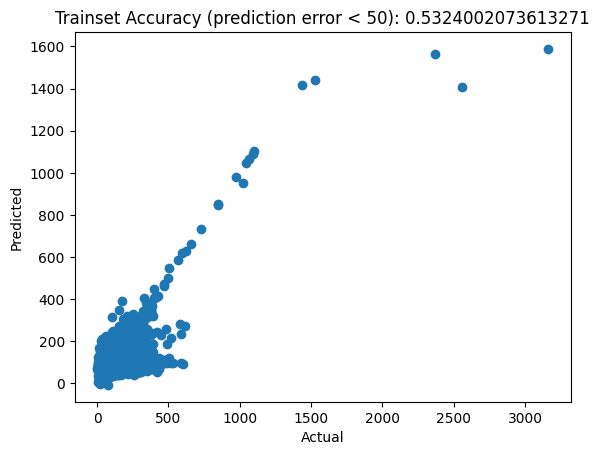

In [20]:

y_pred_mlp = test_mlp_regressor(mlp_regressor, X_train.values if isinstance(X_test, pd.DataFrame) else X_train, np.array(y_test).reshape(-1, 1).squeeze())
y_pred_mlp = np.rint(y_pred_mlp).astype(int)

rounding_graph = 1
rounding = 50

plt.plot(np.floor(y_train//rounding_graph) * rounding_graph, np.floor(y_pred_mlp//rounding_graph) * rounding_graph, 'o')
# accuracy = accuracy_score(np.floor(y_test//rounding) * rounding, np.floor(y_pred_mlp//rounding) * rounding)
accuracy = calculate_accuracy(y_train, y_pred_mlp, rounding)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Trainset Accuracy (prediction error < {}): {}'.format(rounding, accuracy))

Loss: 54.5974


c:\Users\rithi\.conda\envs\kasturi-ml-project\Lib\site-packages\torch\utils\_device.py:77: UserWarning: Using a target size (torch.Size([2412])) that is different to the input size (torch.Size([2412, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


Text(0.5, 1.0, 'Testset Accuracy (prediction error < 50): 0.39344941956882257')

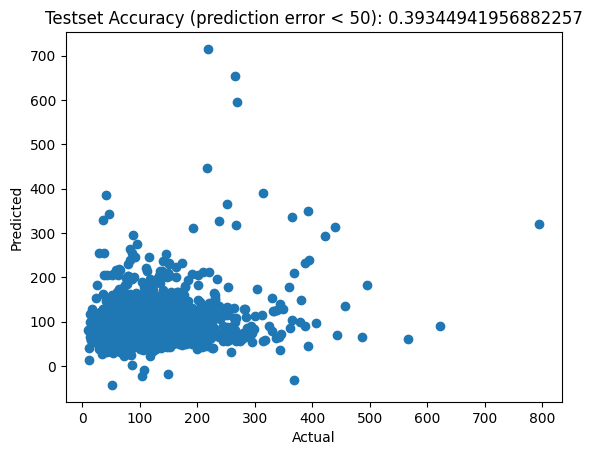

In [21]:

y_pred_mlp = test_mlp_regressor(mlp_regressor, X_test.values if isinstance(X_test, pd.DataFrame) else X_test, np.array(y_test).reshape(-1, 1).squeeze())
y_pred_mlp = np.rint(y_pred_mlp).astype(int)

rounding_graph = 1
rounding = 50

plt.plot(np.floor(y_test//rounding_graph) * rounding_graph, np.floor(y_pred_mlp//rounding_graph) * rounding_graph, 'o')
# accuracy = accuracy_score(np.floor(y_test//rounding) * rounding, np.floor(y_pred_mlp//rounding) * rounding)
accuracy = calculate_accuracy(y_test, y_pred_mlp, rounding)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testset Accuracy (prediction error < {}): {}'.format(rounding, accuracy))

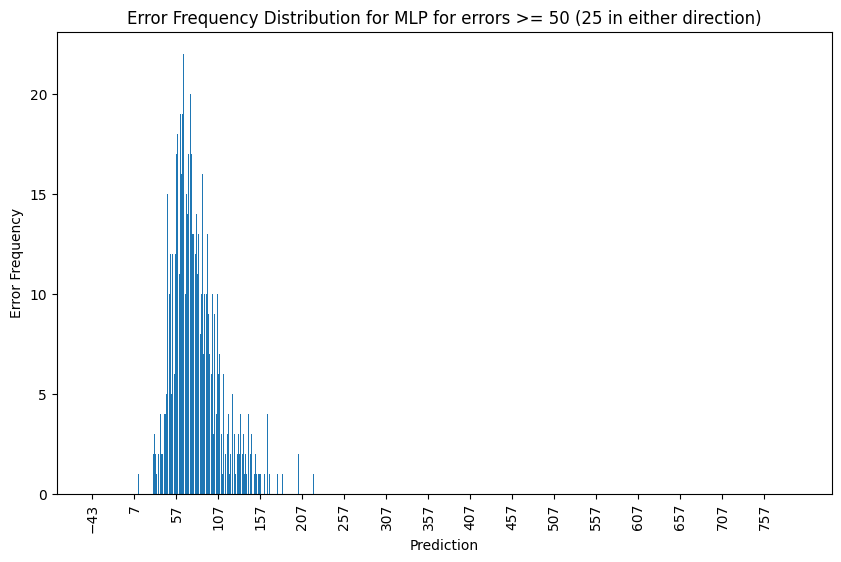

The mean error is 49.06799336650083 and the standard deviation of the errors is 52.77596210623509


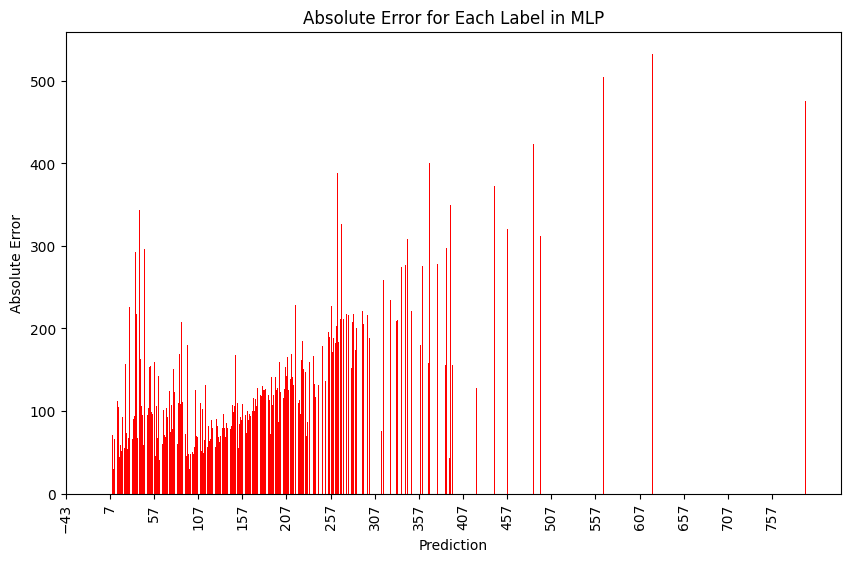

In [22]:
plot_error_frequency(y_pred_mlp, y_test, 'MLP', rounding)

In [23]:
print("Data distribution for train:")
plot_data_distribution(y_train)
print("Data distribution for test:")
plot_data_distribution(y_test)

Data distribution for train:


The mean of the data distribution is 105.31176775531364 and the standard deviation is 86.97503828717436
Data distribution for test:


The mean of the data distribution is 105.31176775531364 and the standard deviation is 86.97503828717436
